In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import pickle
import os
import random
from tqdm import tqdm

In [2]:
# keras
import keras
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, GlobalMaxPool2D
from keras.utils import np_utils
from keras.optimizers import SGD
from livelossplot import PlotLossesKeras
from keras_sequential_ascii import keras2ascii

Using TensorFlow backend.


In [20]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

In [21]:
import seaborn as sn
sn.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams.update({'font.size': 12})
pd.set_option('display.max_columns', 2000)

In [4]:
train_path = "notMNIST_large"
test_path = "notMNIST_small"

In [6]:
X_features = pickle.load(open("X_features.pickle","rb"))
Y_label = pickle.load(open("Y_labels.pickle","rb"))

In [7]:
X_features = np.array(X_features) / 255 # normalization of data for easy to calculations.
Y_label = np.array(Y_label)

In [8]:
resolution = 28
classes = 10

In [9]:
X_features = X_features.reshape((-1, resolution, resolution, 1))
Y_labels = np_utils.to_categorical(Y_label, 10)

In [10]:
TRAIN = 200000
VAL = 10000
TEST = 19000

In [11]:
x_train, y_train = X_features[:TRAIN], Y_labels[:TRAIN]
x_val, y_val = X_features[TRAIN:TRAIN+VAL], Y_labels[TRAIN:TRAIN+VAL]
x_test, y_test = X_features[TRAIN+VAL:TRAIN+VAL+TEST], Y_labels[TRAIN+VAL:TRAIN+VAL+TEST]

In [12]:
x_test, y_test = X_features[TRAIN+VAL:TRAIN+VAL+TEST], Y_label[TRAIN+VAL:TRAIN+VAL+TEST]

In [13]:
print('Train: ',x_train.shape, y_train.shape)
print('Validation: ', x_val.shape, y_val.shape)
print('Test: ', x_test.shape, y_test.shape)

Train:  (200000, 28, 28, 1) (200000, 10)
Validation:  (10000, 28, 28, 1) (10000, 10)
Test:  (19000, 28, 28, 1) (19000,)


In [38]:
model = Sequential()

model.add(Flatten(input_shape=(resolution, resolution, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
             Flatten   ||||| -------------------         0     0.0%
                       #####         784
               Dense   XXXXX -------------------    100480    57.3%
                relu   #####         128
               Dense   XXXXX -------------------     33024    18.8%
                relu   #####         256
               Dense   XXXXX -------------------     32896    18.8%
                relu   #####         128
               Dense   XXXXX -------------------      8256     4.7%
                relu   #####          64
               Dense   XXXXX -------------------       650     0.4%
             softmax   #####          10


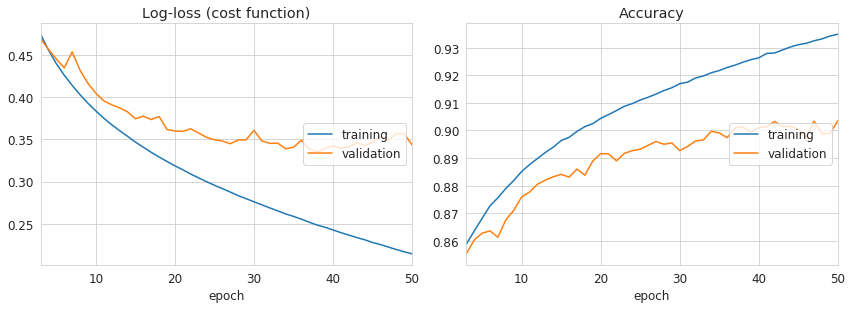

Log-loss (cost function):
training   (min:    0.215, max:    0.528, cur:    0.215)
validation (min:    0.335, max:    0.510, cur:    0.343)

Accuracy:
training   (min:    0.846, max:    0.935, cur:    0.935)
validation (min:    0.846, max:    0.903, cur:    0.903)


In [40]:
model.fit(x_train, y_train,
          epochs=50,
          batch_size=128,
          validation_data=(x_val, y_val),
          callbacks=[PlotLossesKeras()],
          verbose=0)

In [41]:
y_pred = model.predict_classes(x_test)

In [42]:
accuracy_score(y_test, y_pred)

0.9006842105263158

In [43]:
f1_score(y_test, y_pred, average='weighted')

0.9007160279592916

In [44]:
confusion_matrix(y_test, y_pred)

array([[1643,   11,    9,   25,    8,   13,   19,   41,   17,    7],
       [  26, 1632,   12,   73,   34,   13,   43,   45,   28,   11],
       [  10,   10, 1813,   11,   33,   10,   38,   16,   15,    6],
       [  24,   17,    7, 1712,   12,    6,   13,   19,   19,   24],
       [  25,   18,   50,    8, 1736,   17,   39,   10,   23,    9],
       [  16,    7,   16,   22,   24, 1760,   26,   15,   31,   13],
       [  21,   15,   52,   20,   18,   14, 1685,   22,   21,   21],
       [  31,   23,    5,   26,   10,    7,   26, 1658,   30,   10],
       [  34,    8,   29,   31,   23,    8,   27,   22, 1716,   56],
       [  31,    4,   10,   25,    6,   16,   23,   28,   40, 1758]])

### Play with dropout and regularizers

In [59]:
model = Sequential()

model.add(Flatten(input_shape=(resolution, resolution, 1)))
model.add(Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(128,activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(classes, activation='softmax'))
epochs = 50
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
             Flatten   ||||| -------------------         0     0.0%
                       #####         784
               Dense   XXXXX -------------------    100480    57.3%
                relu   #####         128
             Dropout    | || -------------------         0     0.0%
                       #####         128
               Dense   XXXXX -------------------     33024    18.8%
                relu   #####         256
             Dropout    | || -------------------         0     0.0%
                       #####         256
               Dense   XXXXX -------------------     32896    18.8%
                relu   #####         128
             Dropout    | || -------------------         0     0.0%
                       #####         128
               Dense   XXXXX -------------------      8256     4.7%
                relu   #####          64
        

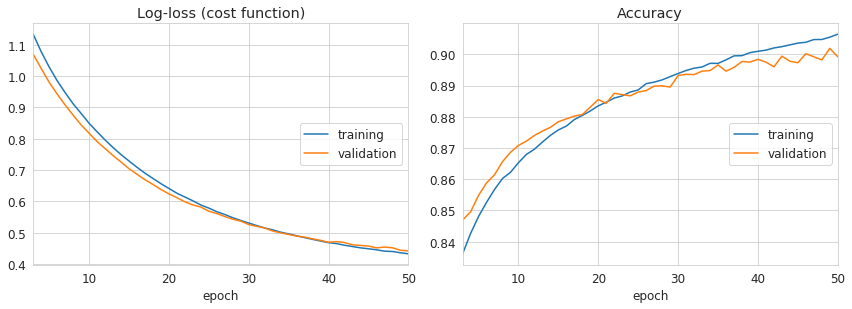

Log-loss (cost function):
training   (min:    0.433, max:    1.575, cur:    0.433)
validation (min:    0.442, max:    1.214, cur:    0.442)

Accuracy:
training   (min:    0.724, max:    0.906, cur:    0.906)
validation (min:    0.828, max:    0.902, cur:    0.899)


In [60]:
model.fit(x_train, y_train,
          epochs=epochs,
          batch_size=128,
          validation_data=(x_val, y_val),
          callbacks=[PlotLossesKeras()],
          verbose=0)

In [61]:
y_pred = model.predict_classes(x_test)

In [62]:
accuracy_score(y_test, y_pred)

0.8993684210526316

In [63]:
f1_score(y_test, y_pred, average='weighted')

0.8994492180075866

In [64]:
confusion_matrix(y_test, y_pred)

array([[1655,   20,    8,   17,    4,    7,   15,   34,   22,   11],
       [  30, 1694,    9,   39,   18,   18,   27,   47,   30,    5],
       [  11,   19, 1788,   11,   32,   13,   54,   12,   15,    7],
       [  32,   43,    2, 1698,    3,   11,   12,   11,   21,   20],
       [  21,   38,   44,   18, 1694,   23,   54,   13,   27,    3],
       [  15,   15,   18,   15,   21, 1740,   32,   19,   32,   23],
       [  26,   32,   32,   19,   10,   12, 1698,   15,   24,   21],
       [  31,   31,    2,   13,    6,   12,   17, 1683,   25,    6],
       [  30,   35,   19,   32,   11,   23,   30,   23, 1694,   57],
       [  29,    8,    8,   31,    8,   15,   22,   21,   55, 1744]])

### Dynamic learning rate

In [53]:
model = Sequential()

model.add(Flatten(input_shape=(resolution, resolution, 1)))
model.add(Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(128,activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(classes, activation='softmax'))
epochs = 50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
             Flatten   ||||| -------------------         0     0.0%
                       #####         784
               Dense   XXXXX -------------------    100480    57.3%
                relu   #####         128
             Dropout    | || -------------------         0     0.0%
                       #####         128
               Dense   XXXXX -------------------     33024    18.8%
                relu   #####         256
             Dropout    | || -------------------         0     0.0%
                       #####         256
               Dense   XXXXX -------------------     32896    18.8%
                relu   #####         128
             Dropout    | || -------------------         0     0.0%
                       #####         128
               Dense   XXXXX -------------------      8256     4.7%
                relu   #####          64
        

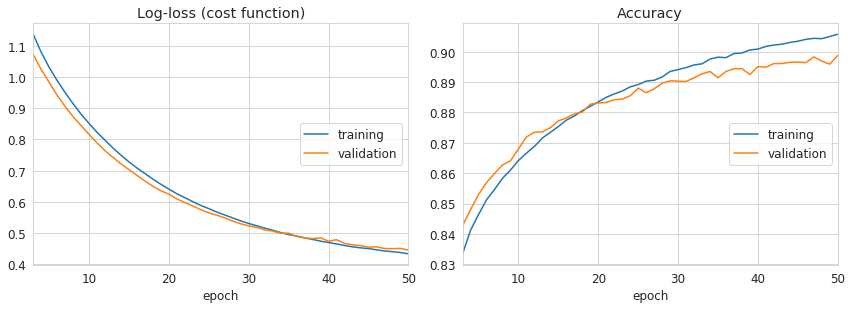

Log-loss (cost function):
training   (min:    0.434, max:    1.605, cur:    0.434)
validation (min:    0.446, max:    1.221, cur:    0.446)

Accuracy:
training   (min:    0.712, max:    0.906, cur:    0.906)
validation (min:    0.819, max:    0.899, cur:    0.899)


In [54]:
model.fit(x_train, y_train,
          epochs=epochs,
          batch_size=128,
          validation_data=(x_val, y_val),
          callbacks=[PlotLossesKeras()],
          verbose=0)

In [55]:
y_pred = model.predict_classes(x_test)

In [56]:
accuracy_score(y_test, y_pred)

0.902578947368421

In [57]:
f1_score(y_test, y_pred, average='weighted')

0.9028796868350255

In [58]:
confusion_matrix(y_test, y_pred)

array([[1649,   23,    5,   11,    6,    6,   18,   23,   45,    7],
       [  23, 1711,    5,   31,   29,   16,   22,   28,   48,    4],
       [  11,   17, 1778,    7,   48,   12,   42,   12,   29,    6],
       [  28,   46,    0, 1685,    6,   10,   10,   10,   40,   18],
       [  24,   30,   34,   12, 1738,   25,   25,    9,   35,    3],
       [  15,   10,   10,   19,   28, 1755,   11,   17,   48,   17],
       [  22,   45,   38,   14,   22,   18, 1654,   20,   42,   14],
       [  21,   35,    1,   17,   10,   12,   15, 1674,   34,    7],
       [  23,   21,   13,   20,   23,   22,   15,   16, 1746,   55],
       [  22,    7,    5,   22,   10,   17,    9,   20,   70, 1759]])